# Programming Assignment 3: Camera Calibration and Fundamental Matrix Estimation with RANSAC
(adapted from the work developed by James Hays, Cusuh Ham, Arvind Krishnakumar, Jing Wu, John Lambert, Samarth Brahmbhatt, Grady Williams, and Henry Hu, which is originally based on a similar project by Aaron Bobick.)

  

## Overview
<font size="4">The goal of this programming assignment is to introduce you to camera and scene geometry. Specifically we will estimate the **camera projection matrix**, which maps 3D world coordinates to image coordinates, as well as the **fundamental matrix**, which relates points in one scene to epipolar lines in another. The camera projection matrix and fundamental matrix can each be estimated using point correspondences. To estimate the projection matrix (camera calibration), the input is corresponding 3D and 2D points. To estimate the fundamental matrix the input is corresponding 2D points across two images. You will start out by estimating the projection matrix and the fundamental matrix for a scene with ground truth correspondences. Then you will move on to estimating the fundamental matrix using point correspondences that are obtained using SIFT.</font>
 
<font size="4">Remember these challenging images of Gaudi’s Episcopal Palace from the programming assignment 2? By using RANSAC to find the fundamental matrix with the most inliers, we can filter away spurious matches and achieve near perfect point-to-point matching as shown below:</font>

<img src='meta_data/gaudi.png' height='1200'/>

<font size="4">For those of you who are passionate about **autonomous driving**, we will have a brief glimpse of the roles of epipolar geometry in this area. In practice, of course, it will be more complicated. For example, you need to deal with dynamic surroundings, different lighting condition, etc. But these fundamental geometric principles are still valuable and necessary.</font> 

## Details
<font size="4">In this programming assignment, you will work on:</font>
* <font size="4">Camera Projection Matrix  </font>
* <font size="4">Fundamental Matrix Estimation  </font>
* <font size="4">Fundamental Matrix with RANSAC   </font>
* <font size="4">Comparison of the results from previous steps</font>
* <font size="4">Using F-Matrix Estimation w/ RANSAC for Visual Odometry </font>

## Submission format
* <font size='4'>`<your_nu_username>.ipynb` (finished this file)
* <font size='4'>`<your_nu_username>.pdf` (your project report)
    
<font size='4'>**Note**: Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Failure to follow any of these instructions will lead to point deductions. 

## Setup

In [1]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pa3_code.utils import (
    verify,
    evaluate_points,
    visualize_points,
    visualize_points_image,
    plot3dview,
    load_image,
    draw_epipolar_lines,
    get_matches,
    show_correspondence2
)

# Programming assignment starts here (100 points in total)

## Part 1: Camera Projection Matrix (20 points including the report)

<font size="4" color="red">**task 1.1: Compute the projection from $[X,Y,Z,1]$ in homogenous coordinates to $(x,y)$ in non-homogenous image coordinates. (2 points).**</font><br><br>

In [2]:
def projection(P: np.ndarray, points_3d: np.ndarray) -> np.ndarray:
    """
    Computes projection from [X,Y,Z,1] in homogenous coordinates to
    (x,y) in non-homogenous image coordinates.
    Args:
        P: 3 x 4 projection matrix
        points_3d: n x 4 array of points [X_i,Y_i,Z_i,1] in homogeneous
            coordinates or n x 3 array of points [X_i,Y_i,Z_i]
    Returns:
        projected_points_2d: n x 2 array of points in non-homogenous image
            coordinates
    """
    projected_points_2d = None

    ###########################################################################
    # TODO: YOUR CODE HERE                                                    #
    ###########################################################################

    x = (P[0,0]*points_3d[:,0] + 
         P[0,1]*points_3d[:,1] + 
         P[0,2]*points_3d[:,2] + 
         P[0,3])/(P[2,0]*points_3d[:,0] + P[2,1]*points_3d[:,1] + P[2,2]*points_3d[:,2] + P[2,3])
    
    y = (P[1,0]*points_3d[:,0] + 
         P[1,1]*points_3d[:,1] + 
         P[1,2]*points_3d[:,2] + 
         P[1,3])/(P[2,0]*points_3d[:,0] + P[2,1]*points_3d[:,1] + P[2,2]*points_3d[:,2] + P[2,3])
    
    projected_points_2d = np.stack((x, y), axis=-1)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return projected_points_2d

In [3]:
# let's check your implementation
from pa3_unit_tests.test_part1 import test_projection
print('projection():', verify(test_projection(projection)))
# test_projection(projection)

projection(): "Correct"


<font size="4" color="red">**task 1.2: Compute the projection matrix (10 points).**</font>

In [4]:
def calculate_projection_matrix(
    points_2d: np.ndarray, points_3d: np.ndarray) -> np.ndarray:
    """
    To solve for the projection matrix. You need to set up a system of
    equations using the corresponding 2D and 3D points.

    Then you can solve this using least squares with np.linalg.lstsq() or SVD.
    Notice you obtain 2 equations for each corresponding 2D and 3D point
    pair. To solve this, you need at least 6 point pairs.

    Args:
        points_2d: A numpy array of shape (N, 2)
        points_3d: A numpy array of shape (N, 3)

    Returns:
        M: A numpy array of shape (3, 4) representing the projection matrix
    """
    ###########################################################################
    # TODO: YOUR CODE HERE                                                    #
    ###########################################################################

    length = points_3d.shape[0]
    idx = 0
    
    A = np.zeros((int(2*points_3d.shape[0]),12))
    
    for i in range(0,length):
        A[idx,0:3] = points_3d[i,:]
        A[idx,3] = 1
        A[idx,8:11] = -points_2d[i,0] * points_3d[i,:]
        A[idx,11] = -points_2d[i,0]
        A[idx+1,4:7] = points_3d[i,:]
        A[idx+1,7] = 1
        A[idx+1,8:11] = -points_2d[i,1] * points_3d[i,:]
        A[idx+1,11] = -points_2d[i,1]
        idx = idx + 2
    
    U, S, VT = np.linalg.svd(A)
    V = VT.T
    
    M1 = V[:,V.shape[1]-1]
    M = np.zeros((3,4))
    M[0,:] = M1[:4]
    M[1,:] = M1[4:8]
    M[2,:] = M1[8:12]    

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return M


In [5]:
# let's check your implementation
from pa3_unit_tests.test_part1 import test_calculate_projection_matrix

print('calculate_projection_matrix():', verify(
    test_calculate_projection_matrix(calculate_projection_matrix)
))

calculate_projection_matrix(): "Correct"


<font size="4" color="red">**task 1.3: Compute the camera center (3 points).**</font>

In [6]:
def calculate_camera_center(M: np.ndarray) -> np.ndarray:
    """
    Returns the camera center matrix for a given projection matrix.

    Args:
    -   M: A numpy array of shape (3, 4) representing the projection matrix

    Returns:
    -   cc: A numpy array of shape (1, 3) representing the camera center
            location in world coordinates
    """
    ###########################################################################
    # TODO: YOUR CODE HERE                                                    #
    ###########################################################################

    Q = M[:,:3]
    cc = -np.linalg.inv(Q) @ M[:,3]

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return cc

In [7]:
# let's check your implementation
from pa3_unit_tests.test_part1 import test_calculate_camera_center

print('test_calculate_camera_center():', verify(
    test_calculate_camera_center(calculate_camera_center)
))

test_calculate_camera_center(): "Correct"


## Now let's see how they work in practice
### Calculate the projection matrix given corresponding 2D & 3D points

points2d: (20, 2)
points3d: (20, 3)
points2d: (20, 2)
points3d: (20, 3)
The projection matrix is
 [[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]
The total residual is 0.777248


<IPython.core.display.Javascript object>


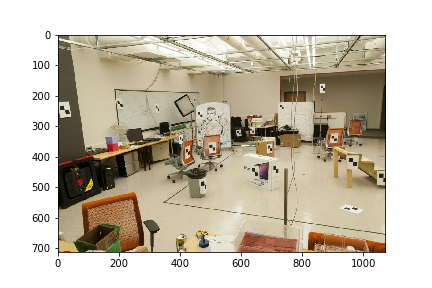

<IPython.core.display.Javascript object>


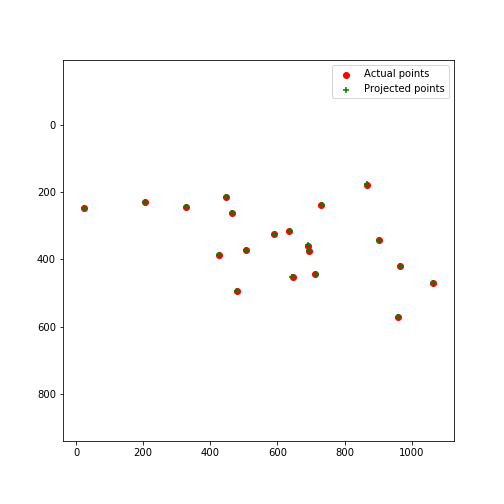

In [8]:
# Load the data
img_path = '../data/CCB_GaTech/pic_a.jpg'
points_2d = np.loadtxt('../data/CCB_GaTech/pts2d-norm-pic_a.txt')
points_3d = np.loadtxt('../data/CCB_GaTech/pts3d-norm.txt')
print('points2d: {}'.format(points_2d.shape))
print('points3d: {}'.format(points_3d.shape))

# (Optional) Uncomment these five lines once you have your code working with the easier, normalized points above.
img_path = '../data/CCB_GaTech/pic_b.jpg'
points_2d = np.loadtxt('../data/CCB_GaTech/pts2d-pic_b.txt')
points_3d = np.loadtxt('../data/CCB_GaTech/pts3d.txt')
print('points2d: {}'.format(points_2d.shape))
print('points3d: {}'.format(points_3d.shape))

M = calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', M)

[projected_2d_pts, residual] = evaluate_points(projection, M, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
plt.figure(); plt.imshow(load_image(img_path))
visualize_points(points_2d, projected_2d_pts)

### Calculate the camera center using M found from the previous step

The estimated location of the camera is <303.1000, 307.1843, 30.4217>


<IPython.core.display.Javascript object>


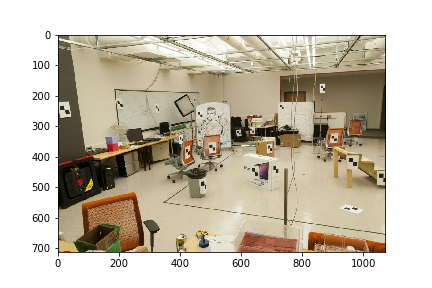

<IPython.core.display.Javascript object>


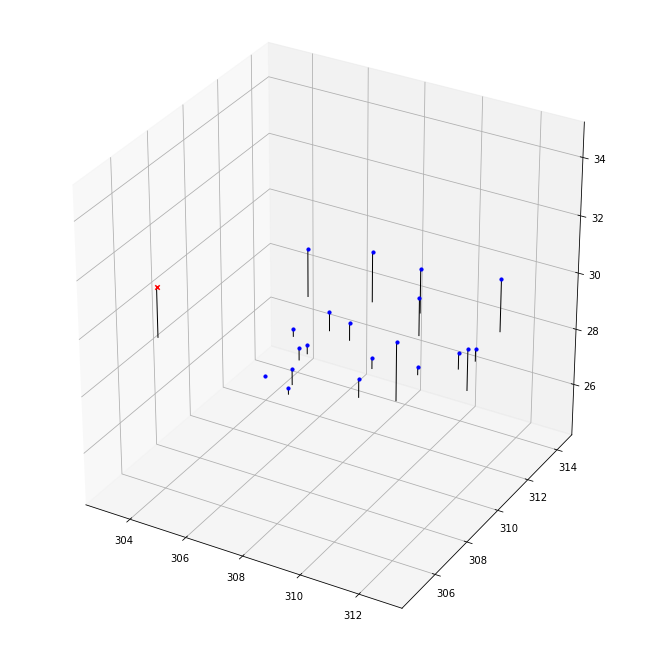

In [9]:
center = calculate_camera_center(M);
print('The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>'.format(*center))
plt.figure(); plt.imshow(load_image(img_path))
ax = plot3dview(points_3d, center)

## Camera Calibration for Argoverse image data
We'll now estimate the position of a camera mounted on an autonomous vehicle, using data from Argoverse. We'll use images from the "ring front center" camera, which faces forward.


<img src="https://www.argoverse.org/assets/images/reference_images/O2V4_vehicle_annotation.jpg" alt="Drawing" style="width: 400px;"/>


In [10]:
# Argoverse Scene 3
img_path = '../data/argoverse_log_d60558d2_pair3/pic3.jpg'
points_2d = np.loadtxt('../data/argoverse_log_d60558d2_pair3/points_2d.txt')
points_3d = np.loadtxt('../data/argoverse_log_d60558d2_pair3/points_3d.txt')
# # # Argoverse Scene 2
# img_path = '../data/argoverse_log_d60558d2_pair2/pic2.jpg'
# points_2d = np.loadtxt('../data/argoverse_log_d60558d2_pair2/points_2d.txt')
# points_3d = np.loadtxt('../data/argoverse_log_d60558d2_pair2/points_3d.txt')

The projection matrix is
 [[-3.21035167e-01  4.78910572e-01  4.67956339e-03  5.32247565e-01]
 [-2.01472423e-01  1.66939011e-03  4.77231906e-01 -3.40480640e-01]
 [-3.40476430e-04  4.27185858e-06  3.97871694e-06  5.63670280e-04]]
The total residual is 0.000000


<IPython.core.display.Javascript object>


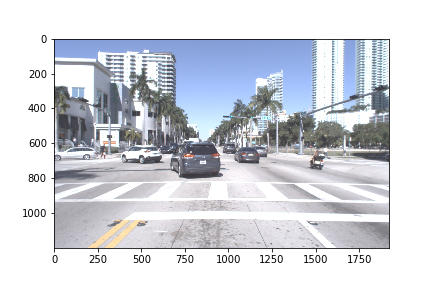

<IPython.core.display.Javascript object>


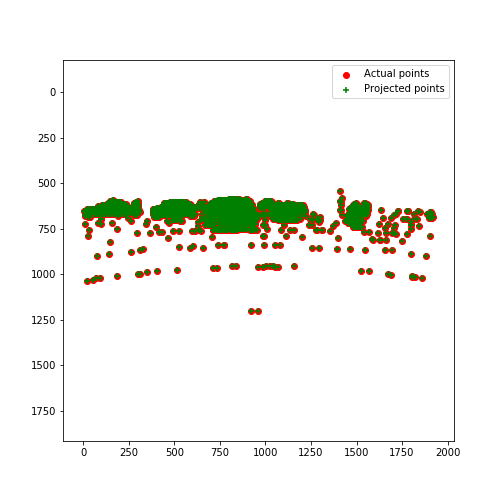

In [11]:
M = calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', M)

[projected_2d_pts, residual] = evaluate_points(projection, M, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
plt.figure(); plt.imshow(load_image(img_path))
visualize_points(points_2d, projected_2d_pts)

For these 2d-3d pairs, the "world" frame is defined as the "ego-vehicle" frame, where the origin is at the center of the back axle of the vehicle.

Thus, if your camera center estimate is correct, it should tell you how far to move forward (+x) and how far to move left (+y) and move up (+z) to reach teh camera's position.


The "egovehicle" coordinate system and "camera" coordinate system:
<img width="300"  src="https://user-images.githubusercontent.com/16724970/108759169-034e6180-751a-11eb-8a06-fbe344f1ee68.png">
<img width="300" src="https://user-images.githubusercontent.com/16724970/108759182-06495200-751a-11eb-8162-8b17f9cdee4b.png">

The estimated location of the camera is <1.6721, -0.0044, 1.4194>


<IPython.core.display.Javascript object>


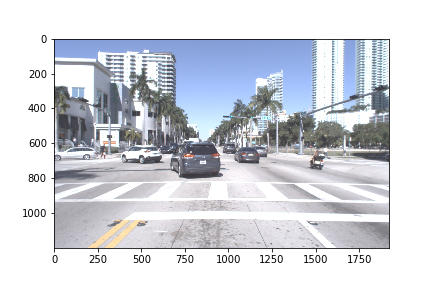

<IPython.core.display.Javascript object>


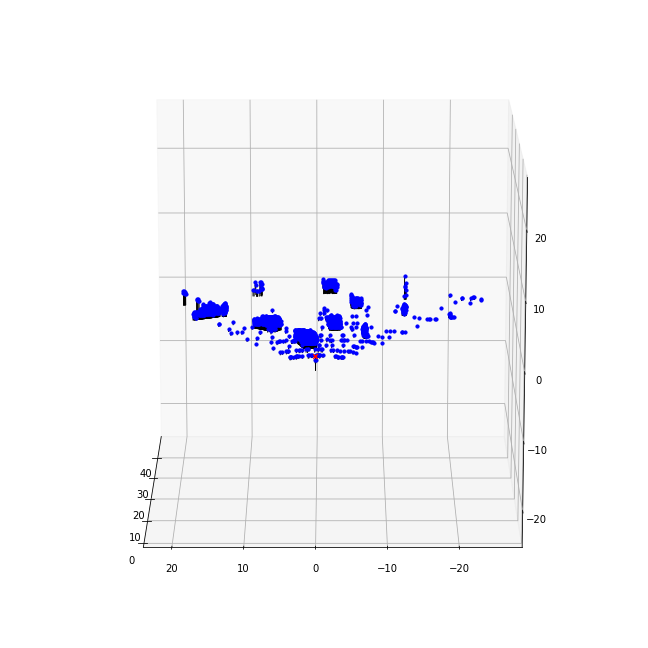

In [12]:
center = calculate_camera_center(M);
print('The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>'.format(*center))
plt.figure(); plt.imshow(load_image(img_path))
ax = plot3dview(points_3d, center)
ax.view_init(elev=15, azim=180)

## Part 2: Fundamental Matrix Estimation (25 points including the report)
<font size="4">We'll now solve for the Fundamental Matrix by implementing [Hartley's 8-Point algorithm](https://www.cse.unr.edu/~bebis/CS485/Handouts/hartley.pdf). We will use the normalized version.</font>

<font size="4" color="red">**task 2.1: Normalize the 2D coordinates (5 points).**</font>

<font size="4">As discussed in the lecture, you can use the following equation to normalize a 2D point.
<img src='meta_data/normalize_point.png' height=10/>
The transform matrix $T$ is the product of the scale and offset matrices. $c_u$ and $c_v$ are the mean coordinates that are to center the image data at the origin. To compute scales $s_u$ and $s_v$ you could estimate the standard deviation after subtracting the means. Then choose the scale factors $s_u$ and $s_v$ so the mean squared distance between the origin and the data points is 2 pixels.

In [13]:
def normalize_points(points: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Perform coordinate normalization through linear transformations.
    Args:
        points: A numpy array of shape (N, 3) representing the 2D points in
            the image

    Returns:
        points_normalized: A numpy array of shape (N, 3) representing the
            normalized 2D points in the image
        T: transformation matrix representing the product of the scale and
            offset matrices
    """
    ###########################################################################
    # TODO: YOUR CODE HERE                                                    #
    ###########################################################################
    
    #print(points.shape)

    meanC = points.mean(axis=0)
    #print(meanC)
    
    stdS = np.mean(np.linalg.norm([points[:,0]-meanC[0],points[:,1]-meanC[1]], axis=0))
    #print(stdS)

    T1 = np.diagflat(np.array([np.sqrt(2)/stdS, np.sqrt(2)/stdS, 1]))
    T2 = np.column_stack((np.row_stack((np.eye(2), [[0, 0]])), [-meanC[0], -meanC[1], 1]))

    T = T1 @ T2
    #print(T)
    
    points_normalized = T @ points.T
    points_normalized = points_normalized.T
    
    #print(points_normalized)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return points_normalized, T

In [14]:
from pa3_unit_tests.test_part2 import test_normalize_points

print('test_normalize_points():', verify(
    test_normalize_points(normalize_points)
))

test_normalize_points(): "Correct"


<font size="4" color="red">**task 2.2: Adjust the fundamental matrix to account for the normalized coordinates (2 points).**</font>
<img src='meta_data/denormalize_F.png' height=10/>

In [15]:
def unnormalize_F(
    F_norm: np.ndarray, T_a: np.ndarray, T_b: np.ndarray) -> np.ndarray:
    """
    Adjusts F to account for normalized coordinates by using the transformation
    matrices.

    Args:
        F_norm: A numpy array of shape (3, 3) representing the normalized
            fundamental matrix
        T_a: Transformation matrix for image A
        T_b: Transformation matrix for image B

    Returns:
        F_orig: A numpy array of shape (3, 3) representing the original
            fundamental matrix
    """
    ###########################################################################
    # TODO: YOUR CODE HERE                                                    #
    ###########################################################################

    F_orig = T_b.T @ F_norm @ T_a

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return F_orig

In [16]:
from pa3_unit_tests.test_part2 import test_unnormalize_F

print('test_unnormalize_F():', verify(
    test_unnormalize_F(unnormalize_F)
))

test_unnormalize_F(): "Correct"


<font size="4" color="red">**task 2.3: Calculate the fundamental matrix with the normalized 8-point algorithm (13 points).**</font>

In [17]:
def estimate_fundamental_matrix(
    points_a: np.ndarray, points_b: np.ndarray) -> np.ndarray:
    """
    Calculates the fundamental matrix. You may use the normalize_points() and
    unnormalize_F() functions here.

    Args:
        points_a: A numpy array of shape (N, 2) representing the 2D points in
            image A
        points_b: A numpy array of shape (N, 2) representing the 2D points in
            image B

    Returns:
        F: A numpy array of shape (3, 3) representing the fundamental matrix
    """
    ###########################################################################
    # TODO: YOUR CODE HERE                                                    #
    ###########################################################################
    
    Points_a = np.column_stack((points_a, [1]*points_a.shape[0]))
    Points_b = np.column_stack((points_b, [1]*points_b.shape[0]))
    
    norm_a, Ta = normalize_points(Points_a)
    norm_b, Tb = normalize_points(Points_b)
    #print(norm_a.shape)
    
    norm_a = np.tile(norm_a, 3)
    norm_b = norm_b.repeat(3, axis=1)
    A = np.multiply(norm_a, norm_b)

    U, S, VT = np.linalg.svd(A)
    #print(VT)
    F_mat = VT[-1].reshape((3,3))
    #print(F_mat)
    
    F_mat = F_mat / np.linalg.norm(F_mat)
    
    U, S, VT = np.linalg.svd(F_mat)
    S[-1] = 0
    F_mat = U @ np.diagflat(S) @ VT
    
    F = unnormalize_F(F_mat,Ta,Tb)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return F


In [18]:
from pa3_unit_tests.test_part2 import test_estimate_fundamental_matrix

print('test_estimate_fundamental_matrix():', verify(
    test_estimate_fundamental_matrix(estimate_fundamental_matrix)
))

test_estimate_fundamental_matrix(): "Correct"


### Estimate fundamental matrix with real-world data

<IPython.core.display.Javascript object>


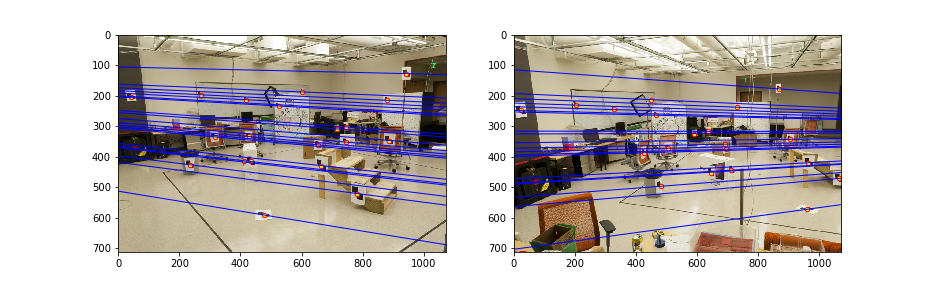

In [19]:
# Load the data
points_2d_pic_a = np.loadtxt('../data/CCB_GaTech/pts2d-pic_a.txt')
points_2d_pic_b = np.loadtxt('../data/CCB_GaTech/pts2d-pic_b.txt')
img_a = load_image('../data/CCB_GaTech/pic_a.jpg')
img_b = load_image('../data/CCB_GaTech/pic_b.jpg')

F = estimate_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(F, img_a, img_b, points_2d_pic_a, points_2d_pic_b, figsize=(13,4))

## Part 3: Fundamental Matrix with RANSAC (25 points including the report)

<font size="4">**Mount Rushmore**: This pair is easy, and most of the initial matches are correct. The base fundamental matrix estimation without coordinate normalization will work fine with RANSAC. 

<font size="4">**Notre Dame**: This pair is difficult because the keypoints are largely on the same plane. Still, even an inaccurate fundamental matrix can do a pretty good job of filtering spurious matches.  

<font size="4">**Gaudi**: This pair is difficult and doesn't find many correct matches unless you run at high resolution, but that will lead to tens of thousands of SIFT features, which will be somewhat slow to process. Normalizing the coordinates seems to make this pair work much better.  

<font size="4">**Woodruff**: This pair has a clearer relationship between the cameras (they are converging and have a wide baseline between them). The estimated fundamental matrix is less ambiguous and you should get epipolar lines qualitatively similar to part 2 of the project.

<font size="4" color="red">**task 3.1: Calculate the number of RANSAC iterations needed for a given guarantee of
    success (3 points).**</font>

In [20]:
def calculate_num_ransac_iterations(
    prob_success: float, sample_size: int, ind_prob_correct: float) -> int:
    """
    Calculates the number of RANSAC iterations needed for a given guarantee of
    success.

    Args:
        prob_success: [float] representing the desired guarantee of success
        sample_size: [int] the number of samples included in each RANSAC
            iteration
        ind_prob_correct: [float] representing the probability that each element
            in a sample is correct

    Returns:
        num_samples: int the number of RANSAC iterations needed

    """
    num_samples = None
    ###########################################################################
    # TODO: YOUR CODE HERE                                                    #
    ###########################################################################

    num_samples = np.log(1 - prob_success) / np.log(1 - (ind_prob_correct ** sample_size))
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return int(num_samples)

In [21]:
from pa3_unit_tests.test_part3 import test_calculate_num_ransac_iterations

print('test_calculate_num_ransac_iterations():', verify(
    test_calculate_num_ransac_iterations(calculate_num_ransac_iterations)
))

test_calculate_num_ransac_iterations(): "Correct"


<font size="4" color="red">**task 3.2: Calculate the fundamental matrix with RANSAC (17 points).**</font><br>
<font size='4'>Note: At most a single for loop can be used in your implementation.</font>

In [22]:
def ransac_fundamental_matrix(
    matches_a: np.ndarray, matches_b: np.ndarray) -> np.ndarray:
    """
    For this section, use RANSAC to find the best fundamental matrix by
    randomly sampling interest points. You would reuse
    estimate_fundamental_matrix() from part 2 of this assignment and
    calculate_num_ransac_iterations().

    If you are trying to produce an uncluttered visualization of epipolar
    lines, you may want to return no more than 30 points for either left or
    right images.

    Tips:
        0. You will need to determine your prob_success, sample_size, and
            ind_prob_success values. What is an acceptable rate of success? How
            many points do you want to sample? What is your estimate of the
            correspondence accuracy in your dataset?
        1. A potentially useful function is numpy.random.choice for creating
            your random samples.
        2. You will also need to choose an error threshold to separate your
            inliers from your outliers.

    Args:
        matches_a: A numpy array of shape (N, 2) representing the coordinates
            of possibly matching points from image A
        matches_b: A numpy array of shape (N, 2) representing the coordinates
            of possibly matching points from image B
    Each row is a correspondence (e.g. row 42 of matches_a is a point that
    corresponds to row 42 of matches_b)

    Returns:
        best_F: A numpy array of shape (3, 3) representing the best fundamental
            matrix estimation
        inliers_a: A numpy array of shape (M, 2) representing the subset of
            corresponding points from image A that are inliers with respect to
            best_F
        inliers_b: A numpy array of shape (M, 2) representing the subset of
            corresponding points from image B that are inliers with respect to
            best_F
    """
    ###########################################################################
    # TODO: YOUR CODE HERE                                                    #
    ###########################################################################

    sample_size = 8
    prob_success = 0.99
    ind_prob_correct = 0.55
    iters = calculate_num_ransac_iterations(prob_success, sample_size, ind_prob_correct)
    #iters = 1000      ## higher number of iterations for precision on complex images
    #print("Num(iterations) : ", iters)
    
    Matches_a = np.column_stack((matches_a, [1]*matches_a.shape[0]))
    Matches_b = np.column_stack((matches_b, [1]*matches_b.shape[0]))
    Matches_a = np.tile(Matches_a, 3)
    Matches_b = Matches_b.repeat(3, axis=1)
    A = np.multiply(Matches_a, Matches_b)
    
    
    r = matches_a.shape[0]
    threshold = 0.002
    #threshold = 0.05
    
    max_count = 0
    best_F = np.zeros((3, 3))

    for i in range(iters):
        
        idx = np.random.randint(r, size = sample_size)
        F_mat = estimate_fundamental_matrix(matches_a[idx, :], matches_b[idx, :])
        #print(F_mat.shape)
        #print(F_mat)
        
        error = np.abs(np.matmul(A, F_mat.reshape((-1))))
        #print(error.shape)
        
        curr_count = 0
        for j in range(r):
            if error[j] <= threshold:
                curr_count += 1
        #print(curr_count)
        
        if curr_count > max_count:
            max_count = curr_count
            best_F = F_mat.copy()

    error = np.abs(np.matmul(A, best_F.reshape((-1))))
    index = np.argsort(error)
    
    inliers_a = matches_a[index[:29]]
    inliers_b = matches_b[index[:29]]
    
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return best_F, inliers_a, inliers_b

In [23]:
# let's check your implementation
from pa3_unit_tests.test_part3 import test_ransac_fundamental_matrix

print('test_ransac_fundamental_matrix():', verify(
    test_ransac_fundamental_matrix(ransac_fundamental_matrix)
))

test_ransac_fundamental_matrix(): "Correct"


### Let's work with real-world data

In [24]:
# Load the data
# Mount Rushmore
# pic_a = load_image('../data/Mount_Rushmore/9193029855_2c85a50e91_o.jpg'); scale_a = 0.25
# pic_b = load_image('../data/Mount_Rushmore/7433804322_06c5620f13_o.jpg'); scale_b = 0.37
# n_feat = 5e4

# Notre Dame
# pic_a = load_image('../data/Notre_Dame/921919841_a30df938f2_o.jpg'); scale_a = 0.5
# pic_b = load_image('../data/Notre_Dame/4191453057_c86028ce1f_o.jpg'); scale_b = 0.5
# n_feat = 4e3

# Gaudi
# pic_a = load_image('../data/Episcopal_Gaudi/3743214471_1b5bbfda98_o.jpg'); scale_a = 0.8
# pic_b = load_image('../data/Episcopal_Gaudi/4386465943_8cf9776378_o.jpg'); scale_b = 1.0
# n_feat = 2e4

# Woodruff
pic_a = load_image('../data/Woodruff_Dorm/wood1.jpg'); scale_a = 0.65
pic_b = load_image('../data/Woodruff_Dorm/wood2.jpg'); scale_b = 0.65
n_feat = 5e4

pic_a = cv2.resize(pic_a, None, fx=scale_a, fy=scale_a)
pic_b = cv2.resize(pic_b, None, fx=scale_b, fy=scale_b)

Found 486 possibly matching features


<IPython.core.display.Javascript object>


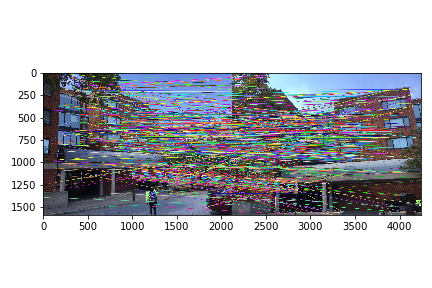

In [25]:
# Finds matching points in the two images using OpenCV's implementation of SIFT.
# There can still be many spurious matches, though.
points_2d_pic_a, points_2d_pic_b = get_matches(pic_a, pic_b, n_feat)
print('Found {:d} possibly matching features'.format(len(points_2d_pic_a)))
match_image = show_correspondence2(pic_a, pic_b,
                                   points_2d_pic_a[:, 0], points_2d_pic_a[:, 1],
                                   points_2d_pic_b[:, 0], points_2d_pic_b[:, 1])
plt.figure(); plt.imshow(match_image)
plt.tight_layout()

### Calculate the Fundamental Matrix using RANSAC
<font size='4'>Compare your results on the Notre Dame image pair below to your results from Project 2. How accurate do the point correspondences look now? 

<IPython.core.display.Javascript object>


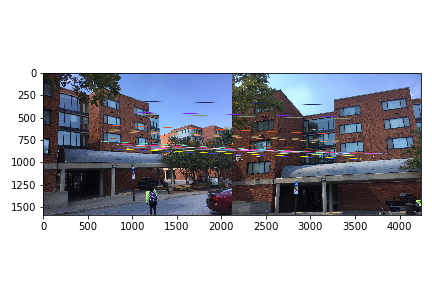

In [26]:
F, matched_points_a, matched_points_b = ransac_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw the epipolar lines on the images and corresponding matches
match_image = show_correspondence2(
    pic_a,
    pic_b,
    matched_points_a[:, 0], matched_points_a[:, 1],
    matched_points_b[:, 0], matched_points_b[:, 1]
)
plt.figure(); plt.imshow(match_image)
plt.tight_layout()

<IPython.core.display.Javascript object>


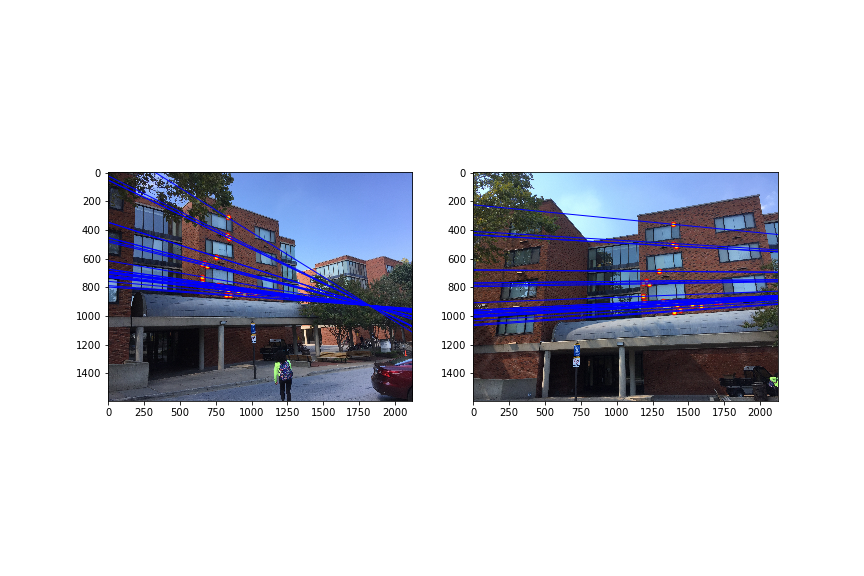

In [27]:
draw_epipolar_lines(F, pic_a, pic_b, matched_points_a, matched_points_b, figsize=(12,8))

## Part 4: Performance Comparison (12 points for the report)
<font size='4'>We'll now test the quality of Fundamental matrices we can compute with and without RANSAC on an image pair from the [Argoverse](https://www.argoverse.org/) autonomous driving dataset. Does RANSAC improve the results?

In [28]:
pic_a = load_image('../data/argoverse_log_273c1883/ring_front_center_315975640448534784.jpg'); scale_a = 0.5
pic_b = load_image('../data/argoverse_log_273c1883/ring_front_center_315975643412234000.jpg'); scale_b = 0.5

n_feat = 4e3
num_matches_to_plot = 50

pic_a = cv2.resize(pic_a, None, fx=scale_a, fy=scale_a)
pic_b = cv2.resize(pic_b, None, fx=scale_b, fy=scale_b)

Found 209 possibly matching features


<IPython.core.display.Javascript object>


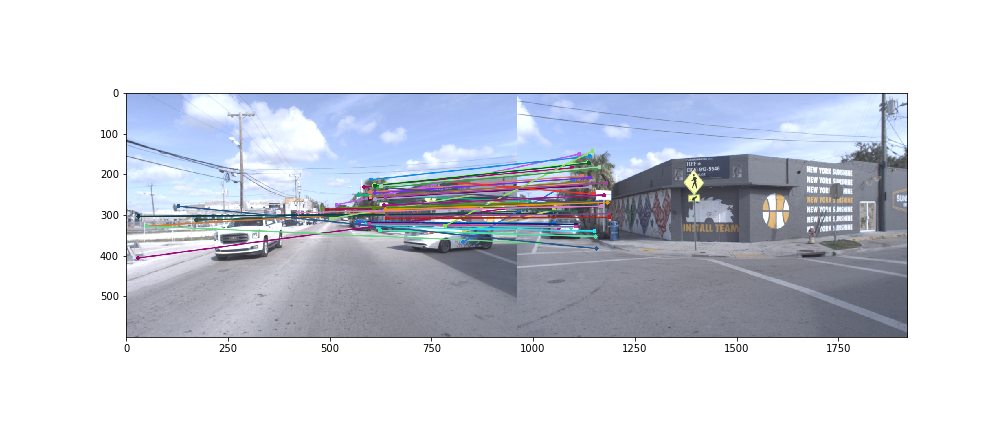

In [29]:
points_2d_pic_a, points_2d_pic_b = get_matches(pic_a, pic_b, n_feat)

print('Found {:d} possibly matching features'.format(len(points_2d_pic_a)))
match_image = show_correspondence2(
    pic_a,
    pic_b,
    points_2d_pic_a[:num_matches_to_plot , 0],
    points_2d_pic_a[:num_matches_to_plot , 1],
    points_2d_pic_b[:num_matches_to_plot , 0],
    points_2d_pic_b[:num_matches_to_plot , 1]
)
plt.figure(figsize=(14,6)); plt.imshow(match_image)

### Without RANSAC Estimation
<font size='4'>If we ignore RANSAC and use only our implementation from Part2, we get the following results:</font>

<IPython.core.display.Javascript object>


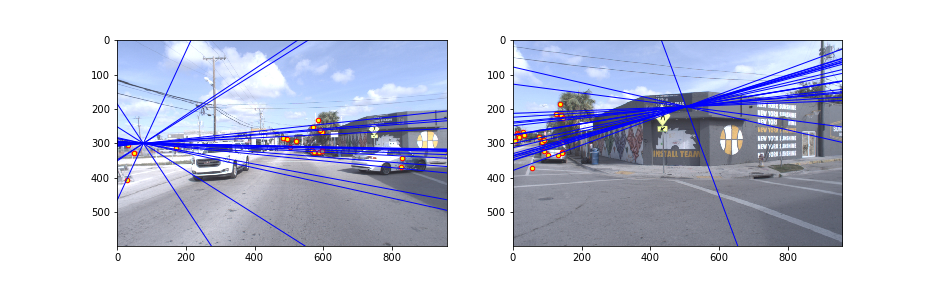

In [30]:
F_wo_ransac = estimate_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw epipolar lines using the fundamental matrix
#points_2d_pic_a = points_2d_pic_a[:20, :]
#points_2d_pic_b = points_2d_pic_b[:20, :]
draw_epipolar_lines(F_wo_ransac, pic_a, pic_b, points_2d_pic_a[:20], points_2d_pic_b[:20], figsize=(13,4))

### With Ransac Estimation
<font size='4'>Now we'll use our RANSAC implementation from Part 3. Where does the epipole fall in the left image? (think about what it represents). The camera is mounted on an autonomous vehicle identical to the vehicle seen up ahead in the left image.</font>

<IPython.core.display.Javascript object>


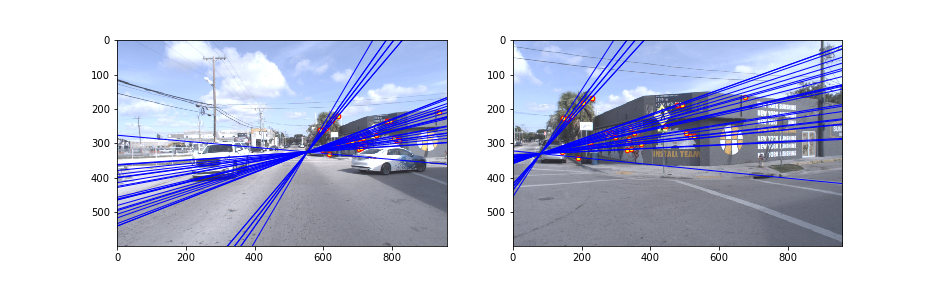

<IPython.core.display.Javascript object>


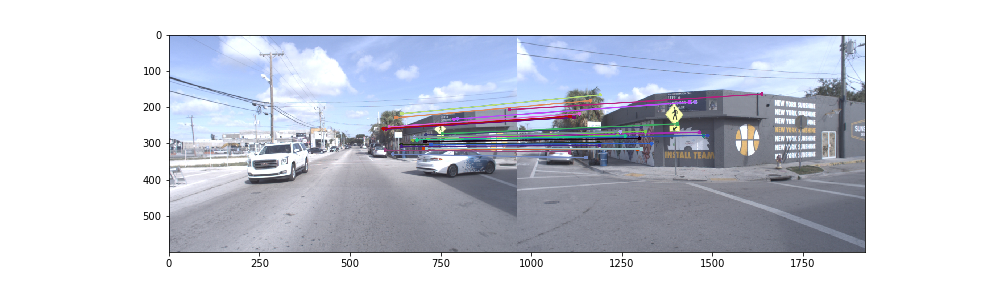

In [31]:
F, matched_points_a, matched_points_b = ransac_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# idxes = np.random.choice(matched_points_a.shape[0], 50)
# matched_points_a = matched_points_a[idxes, :]
# matched_points_b = matched_points_b[idxes, :]

draw_epipolar_lines(F, pic_a, pic_b, matched_points_a, matched_points_b, figsize=(13,4))

# match_image = show_correspondence2(
#     pic_a,
#     pic_b,
#     points_2d_pic_a[:num_matches_to_plot , 0],
#     points_2d_pic_a[:num_matches_to_plot , 1],
#     points_2d_pic_b[:num_matches_to_plot , 0],
#     points_2d_pic_b[:num_matches_to_plot , 1]
# )
match_image = show_correspondence2(
    pic_a,
    pic_b,
    matched_points_a[:num_matches_to_plot , 0],
    matched_points_a[:num_matches_to_plot , 1],
    matched_points_b[:num_matches_to_plot , 0],
    matched_points_b[:num_matches_to_plot , 1]
)
plt.figure(figsize=(14,4)); plt.imshow(match_image)

## Part 5: Visual Odometry (18 points including the report)

For the following gif, we try to obtain the visual odometry of a camera mounted on a robot from the individual image frames.

![VO](https://user-images.githubusercontent.com/16724970/100487935-34fd8b00-30d9-11eb-9941-7735fcae445c.gif "VO")

<font size="4" color="Red">**5.1: Convert a fundamental matrix to the essential matrix (4 points).**</font>

In [32]:
def get_emat_from_fmat(F: np.ndarray, K1: np.ndarray, K2: np.ndarray) -> np.ndarray:
    """ 
    Create essential matrix from camera instrinsics and fundamental matrix
    Args:
        F:  A numpy array of shape (3, 3) representing the fundamental matrix between
            two cameras
        K1: A numpy array of shape (3, 3) representing the intrinsic matrix of the
            first camera
        K2: A numpy array of shape (3, 3) representing the intrinsic matrix of the
            second camera

    Returns:
        E:  A numpy array of shape (3, 3) representing the essential matrix between
            the two cameras.
    """
    ###########################################################################
    # TODO: YOUR CODE HERE                                                    #
    ###########################################################################
    
    E = K2.T @ F @ K1

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return E

In [33]:
# let's check your implementation
from pa3_unit_tests.test_part5 import test_get_emat_from_fmat

print('test_get_emat_from_fmat():', verify(
    test_get_emat_from_fmat(get_emat_from_fmat)
))

test_get_emat_from_fmat(): "Correct"


### Let's see check the visual odometry estimations on a real-world autonomous driving sequence

In [34]:
from pa3_code.vo import get_visual_odometry, plot_poses, evaluate_poses

# This may take a few minutes to run across 20 image frames from the Argoverse dataset
poses_wTi = get_visual_odometry(get_emat_from_fmat, ransac_fundamental_matrix)

Rotation about y-axis from frame 0 -> 1: 0.31 degrees
Rotation about y-axis from frame 1 -> 2: 0.40 degrees
Rotation about y-axis from frame 2 -> 3: 0.59 degrees
Rotation about y-axis from frame 3 -> 4: 0.90 degrees
Rotation about y-axis from frame 4 -> 5: 1.51 degrees
Rotation about y-axis from frame 5 -> 6: 2.10 degrees
Rotation about y-axis from frame 6 -> 7: 3.54 degrees
Rotation about y-axis from frame 7 -> 8: 6.02 degrees
Rotation about y-axis from frame 8 -> 9: 7.76 degrees
Rotation about y-axis from frame 9 -> 10: 8.59 degrees
Rotation about y-axis from frame 10 -> 11: 9.95 degrees
Rotation about y-axis from frame 11 -> 12: 11.01 degrees
Rotation about y-axis from frame 12 -> 13: 11.45 degrees
Rotation about y-axis from frame 13 -> 14: 10.63 degrees
Rotation about y-axis from frame 14 -> 15: 8.88 degrees
Rotation about y-axis from frame 15 -> 16: 6.32 degrees
Rotation about y-axis from frame 16 -> 17: 3.31 degrees
Rotation about y-axis from frame 17 -> 18: 0.96 degrees
Rotation

### Red dots denote ground-truth camera poses and green ones are the estimations

<IPython.core.display.Javascript object>


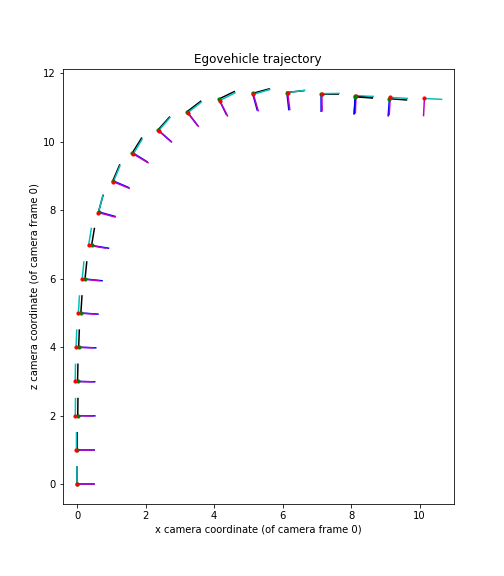

Average rotation error (in degree): 0.21101310831220693
Average angular error of translation (in degree): 10.51881902822607


In [35]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
poses_wTi_gt = np.load('../data/vo_seq_argoverse_273c1883/gt_poses.npy')
plot_poses(poses_wTi, poses_wTi_gt)
avg_r_err, avg_t_err = evaluate_poses(poses_wTi, poses_wTi_gt)
print('Average rotation error (in degree): {}'.format(avg_r_err))
print('Average angular error of translation (in degree): {}'.format(avg_t_err))

## Extra credit: Structure from Motion (SfM) (10 points)
<font size='4'>Note: this time the questions in the extra credit part are much more challenging than before. </font>

<font size="4" color="Red">**1: Perform triagulation to get 3D points (5 points).**</font>

<img src='meta_data/triagulation.png' height='1200'/>

In [36]:
def triangulate(P1, P2, pts1, pts2):
    worldpts = []

    for i in range(pts1.shape[0]):
        A = np.array([   pts1[i,0] * P1[2,:] - P1[0,:] ,
                         pts1[i,1] * P1[2,:] - P1[1,:] ,
                         pts2[i,0] * P2[2,:] - P2[0,:] ,
                         pts2[i,1] * P2[2,:] - P2[1,:]   ])

        # print('A shape: ', A.shape)
        U, S, VT = np.linalg.svd(A)
        V = VT.T
        P = V[:,-1]
        P = P / P[-1]
        # print(P)
        
        worldpts.append(P)

    worldpts = np.asarray(worldpts)

    #print('3D world pts: ', worldpts)]

    #non-homogenous points
    #worldpts = worldpts[:, :-1]

    return worldpts

pts1 = np.loadtxt('../data/CCB_GaTech/pts2d-pic_a.txt')
pts2 = np.loadtxt('../data/CCB_GaTech/pts2d-pic_b.txt')
#print(pts1.shape)

F = estimate_fundamental_matrix(pts1, pts2)
#print(F.shape)
#intrinsic matrix obtained from unit tests
K = np.array([[1000, 0, 2000], [0, 1000, 1000], [0, 0, 1]])

E = get_emat_from_fmat(F, K, K)
R1, R2, t = cv2.decomposeEssentialMat(E)

#4 possible camera matrices
R = [R1, R1, R2, R2]
t = [t, -t, t, -t]

temp = 0
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
for i in range(len(R)):
    P2 = K @ np.hstack((R[i], t[i]))
    #print(P2)
    points = triangulate(P1, P2, pts1, pts2)
    correct = np.sum(points[:,2] > 0)
    if correct > temp:
        temp = correct
        pts3D = points
print("Triangulated points : ",pts3D)
    

Triangulated points :  [[-0.70052371 -0.37946937  0.60183013  1.        ]
 [-0.87482024 -0.30168548  0.44152874  1.        ]
 [-0.84255509 -0.32282559  0.47876759  1.        ]
 [-0.6992235  -0.3337245   0.61307279  1.        ]
 [-0.75774933 -0.34291044  0.59019597  1.        ]
 [-0.65075261 -0.39903464  0.58352532  1.        ]
 [-0.811056   -0.21951459  0.53232159  1.        ]
 [-0.81999587 -0.33326624  0.50855427  1.        ]
 [-0.84713855 -0.29113047  0.49840325  1.        ]
 [-0.72548819 -0.25999581  0.59242957  1.        ]
 [-0.86810403 -0.25988126  0.48969094  1.        ]
 [-0.75061332 -0.2806477   0.55654635  1.        ]
 [-0.777962   -0.31215894  0.56988061  1.        ]
 [-0.82675687 -0.30068106  0.51936083  1.        ]
 [-0.82992357 -0.27372272  0.51894652  1.        ]
 [-0.76020598 -0.32697164  0.59516075  1.        ]
 [-0.81935813 -0.2734438   0.51941153  1.        ]
 [-0.79805875 -0.33723489  0.52969994  1.        ]
 [-0.76959213 -0.3395204   0.58675723  1.        ]
 [-0.779

<font size="4" color="Red">**2: Perform bundle adjustment to use multi-view constraints for better estimations of camera poses and 3D points (5 points).**</font>